<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_14_class_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Load & Clean Data

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import logging
from loan_data_utils import load_and_preprocess_data

# Set up logging
logging.basicConfig(level=logging.INFO)

# Parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Class Imbalance Plot

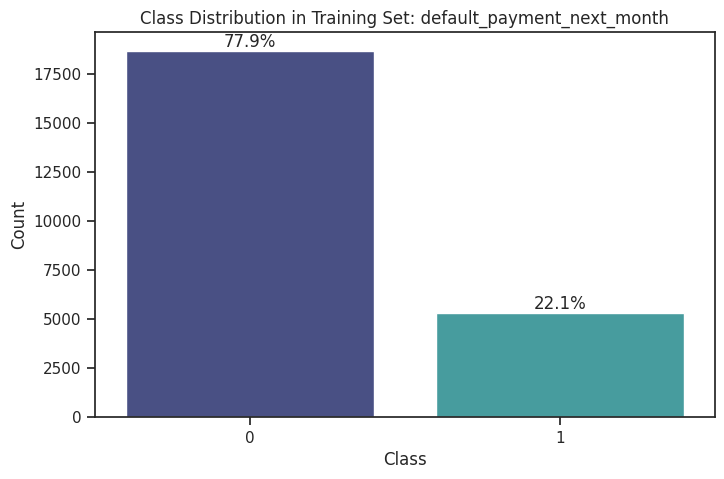

In [22]:
# Plot class distribution in the training set
def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

# Plot class distribution
plot_class_distribution(y_train, target)

### Baseline Model

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, recall_score, f1_score

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define the logistic regression model with class weights
model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
# model = SVC(random_state=42, class_weight='balanced', probability=True, max_iter=1000)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
recall_class1 = recall_score(y_test, y_pred, pos_label=1)
f1_balanced = f1_score(y_test, y_pred, average='binary', pos_label=1)
f1_macro = f1_score(y_test, y_pred, average='macro')

print("Baseline Model Performance:")
print(f"Recall Class 1: {recall_class1:.4f}")
print(f"F1 Score (balanced): {f1_balanced:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Baseline Model Performance:
Recall Class 1: 0.6323
F1 Score (balanced): 0.4649
F1 Score (macro): 0.6174

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      4673
           1       0.37      0.63      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.70      6000



### Run Resampling Methods

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
import logging
from loan_data_utils import load_and_preprocess_data

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define the logistic regression model with class weights
model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Fit the baseline pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict the test data
y_pred = pipeline.predict(X_test)

# Evaluate the baseline model
recall_class1 = recall_score(y_test, y_pred, pos_label=1)
f1_balanced = f1_score(y_test, y_pred, average='binary', pos_label=1)
f1_macro = f1_score(y_test, y_pred, average='macro')

print("Baseline Logistic Regression Model Performance:")
print(f"Recall Class 1: {recall_class1:.4f}")
print(f"F1 Score (balanced): {f1_balanced:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Define a function to evaluate resampling methods
def evaluate_resampling(X_train, y_train, resampler, method_name):
    X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)
    pipeline.fit(X_resampled, y_resampled)
    y_pred = pipeline.predict(X_test)

    recall_class1 = recall_score(y_test, y_pred, pos_label=1)
    f1_balanced = f1_score(y_test, y_pred, average='binary', pos_label=1)
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"{method_name} Model Performance:")
    print(f"Recall Class 1: {recall_class1:.4f}")
    print(f"F1 Score (balanced): {f1_balanced:.4f}")
    print(f"F1 Score (macro): {f1_macro:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return {
        'Method': method_name,
        'Recall Class 1': recall_class1,
        'F1 Score (balanced)': f1_balanced,
        'F1 Score (macro)': f1_macro
    }

# Evaluate different resampling methods
methods = [
    ('Random Undersampling', RandomUnderSampler(random_state=42)),
    ('Random Oversampling', RandomOverSampler(random_state=42)),
    ('SMOTE', SMOTE(random_state=42))
]

results = []
for method_name, resampler in methods:
    result = evaluate_resampling(X_train, y_train, resampler, method_name)
    results.append(result)

Baseline Logistic Regression Model Performance:
Recall Class 1: 0.6323
F1 Score (balanced): 0.4649
F1 Score (macro): 0.6174

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      4673
           1       0.37      0.63      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.70      6000

Random Undersampling Model Performance:
Recall Class 1: 0.6292
F1 Score (balanced): 0.4645
F1 Score (macro): 0.6178

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      4673
           1       0.37      0.63      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.70      6000

Random Oversampling Model Performance:
Recall Class 1: 0.6

#### Compare Results

In [12]:
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results
print("Performance Metrics for Different Resampling Methods:")
results_df

Performance Metrics for Different Resampling Methods:


,Method,Recall Class 1,F1 Score (balanced),F1 Score (macro)
0,Random Undersampling,0.629239,0.464534,0.617752
1,Random Oversampling,0.632253,0.462769,0.615072
2,SMOTE,0.583271,0.450918,0.615444


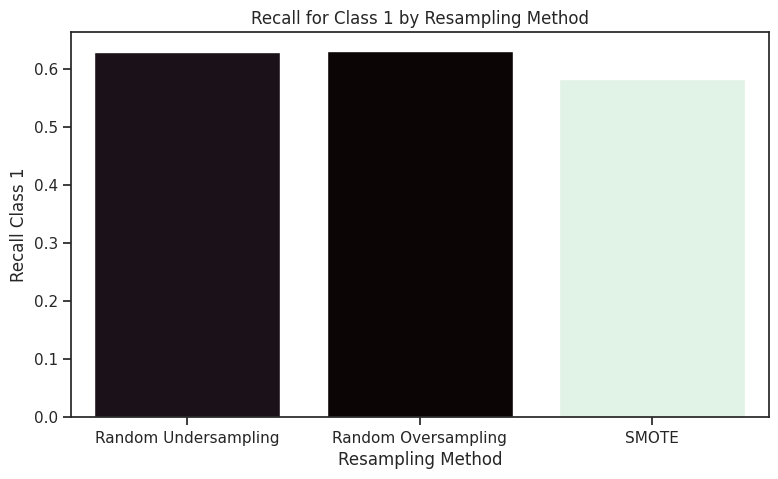

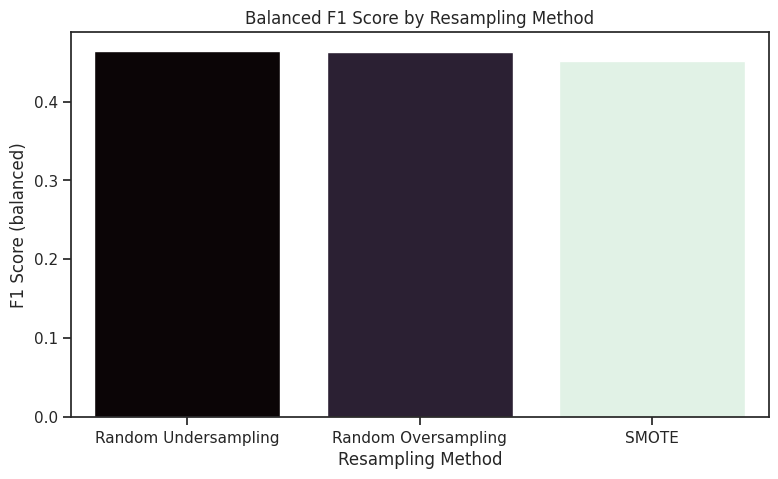

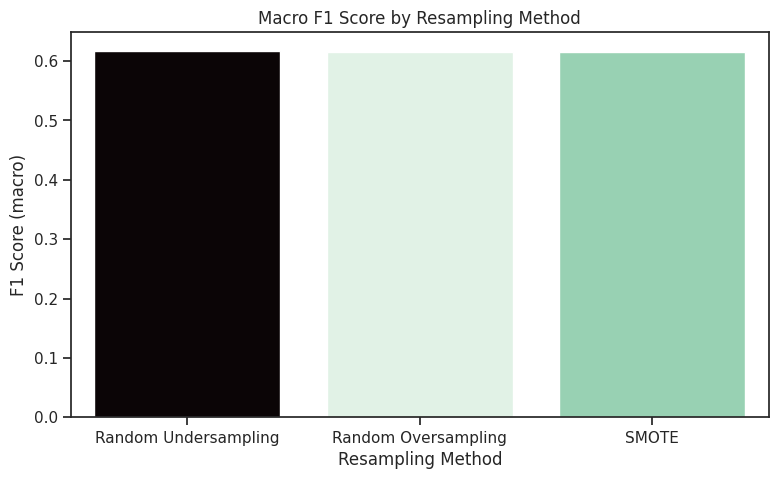

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot the performance metrics
def plot_metrics(results_df, metric, title, ylabel):
    sns.set_context('notebook')
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=(9, 5))

    sns.barplot(x='Method', y=metric, data=results_df, hue=metric, palette='mako_r', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Resampling Method')
    ax.set_ylabel(ylabel)

    # Remove legend
    ax.legend([], [], frameon=False)

    plt.show()

# Metrics to plot
metrics = [
    ('Recall Class 1', 'Recall for Class 1 by Resampling Method', 'Recall Class 1'),
    ('F1 Score (balanced)', 'Balanced F1 Score by Resampling Method', 'F1 Score (balanced)'),
    ('F1 Score (macro)', 'Macro F1 Score by Resampling Method', 'F1 Score (macro)')
]

# Loop through the metrics and create plots
for metric, title, ylabel in metrics:
    plot_metrics(results_df, metric, title, ylabel)


### Resampling with Optimal Threshold

Random Undersampling Model Performance with Threshold 0.25:
Recall Class 1: 0.9231
F1 Score (balanced): 0.3786
F1 Score (macro): 0.3255

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27      4673
           1       0.24      0.92      0.38      1327

    accuracy                           0.33      6000
   macro avg       0.56      0.54      0.33      6000
weighted avg       0.74      0.33      0.30      6000

Random Oversampling Model Performance with Threshold 0.25:
Recall Class 1: 0.9239
F1 Score (balanced): 0.3789
F1 Score (macro): 0.3258

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27      4673
           1       0.24      0.92      0.38      1327

    accuracy                           0.33      6000
   macro avg       0.56      0.54      0.33      6000
weighted avg       0.74      0.33      0.30      6000

SMOTE Model Performance wit

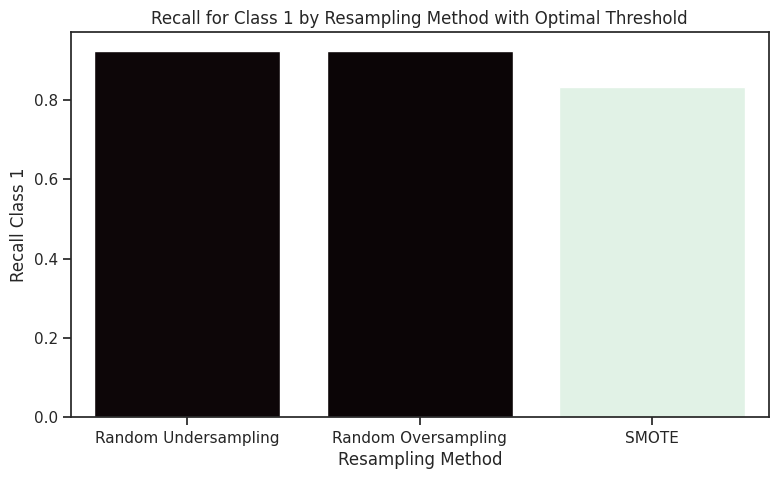

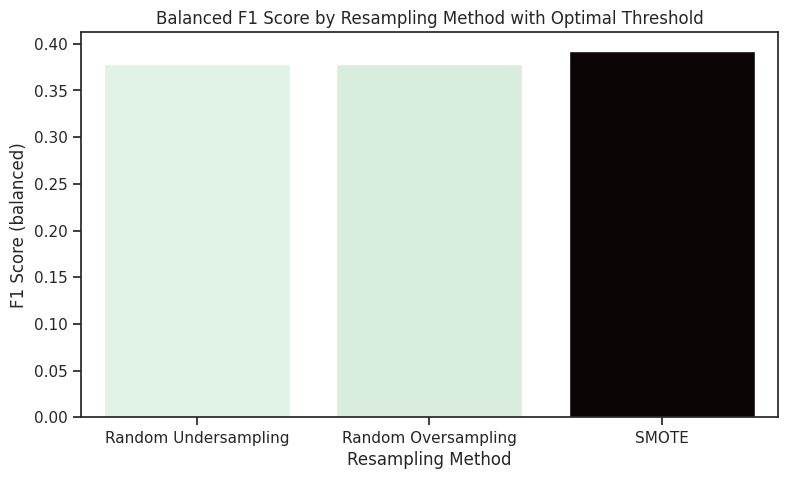

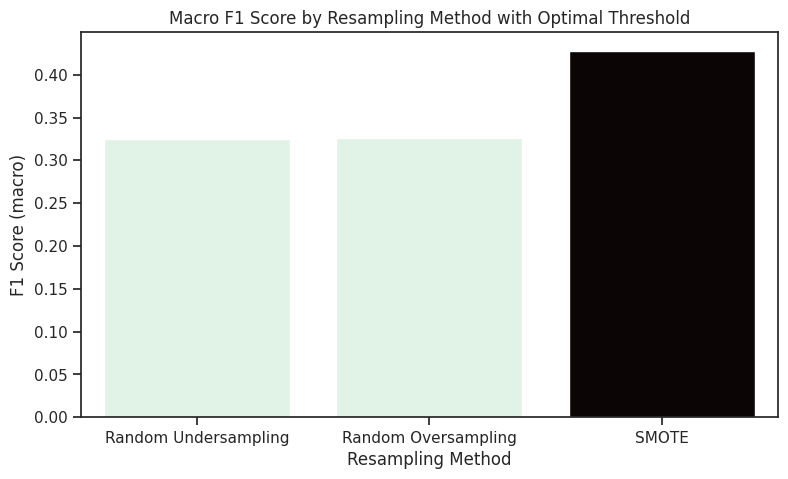

In [27]:
from sklearn.metrics import classification_report, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Define the optimal threshold
optimal_threshold = 0.25

# Function to evaluate resampling methods with the optimal threshold
def evaluate_resampling_with_threshold(X_train, y_train, resampler, method_name, threshold):
    X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)
    pipeline.fit(X_resampled, y_resampled)

    y_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    recall_class1 = recall_score(y_test, y_pred, pos_label=1)
    f1_balanced = f1_score(y_test, y_pred, average='binary', pos_label=1)
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"{method_name} Model Performance with Threshold {threshold}:")
    print(f"Recall Class 1: {recall_class1:.4f}")
    print(f"F1 Score (balanced): {f1_balanced:.4f}")
    print(f"F1 Score (macro): {f1_macro:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return {
        'Method': method_name,
        'Recall Class 1': recall_class1,
        'F1 Score (balanced)': f1_balanced,
        'F1 Score (macro)': f1_macro
    }

# Evaluate different resampling methods with the optimal threshold
methods = [
    ('Random Undersampling', RandomUnderSampler(random_state=42)),
    ('Random Oversampling', RandomOverSampler(random_state=42)),
    ('SMOTE', SMOTE(random_state=42))
]

results_with_threshold = []
for method_name, resampler in methods:
    result = evaluate_resampling_with_threshold(X_train, y_train, resampler, method_name, optimal_threshold)
    results_with_threshold.append(result)

# Convert results to DataFrame for better visualization
results_with_threshold_df = pd.DataFrame(results_with_threshold)

# Metrics to plot
metrics = [
    ('Recall Class 1', 'Recall for Class 1 by Resampling Method with Optimal Threshold', 'Recall Class 1'),
    ('F1 Score (balanced)', 'Balanced F1 Score by Resampling Method with Optimal Threshold', 'F1 Score (balanced)'),
    ('F1 Score (macro)', 'Macro F1 Score by Resampling Method with Optimal Threshold', 'F1 Score (macro)')
]

# Loop through the metrics and create plots
for metric, title, ylabel in metrics:
    plot_metrics(results_with_threshold_df, metric, title, ylabel)


In [26]:
# Display the results
print("Performance Metrics for Different Resampling Methods with Optimal Threshold:")
print(results_with_threshold_df)

Performance Metrics for Different Resampling Methods with Optimal Threshold:
                 Method  Recall Class 1  F1 Score (balanced)  F1 Score (macro)
0  Random Undersampling        0.923135             0.378554          0.325493
1   Random Oversampling        0.923888             0.378863          0.325828
2                 SMOTE        0.832705             0.392749          0.428291


#### Combine All Results

In [30]:
# Add a column to differentiate between the baseline and optimal threshold results
results_df['Threshold'] = 'Default'
results_with_threshold_df['Threshold'] = 'Optimal (0.25)'

# Combine the two DataFrames
final_results_df = pd.concat([results_df, results_with_threshold_df], ignore_index=True)

# Display the combined results
print("Combined Performance Metrics for Resampling Methods:")
final_results_df

Combined Performance Metrics for Resampling Methods:


,Method,Recall Class 1,F1 Score (balanced),F1 Score (macro),Threshold
0,Random Undersampling,0.629239,0.464534,0.617752,Default
1,Random Oversampling,0.632253,0.462769,0.615072,Default
2,SMOTE,0.583271,0.450918,0.615444,Default
3,Random Undersampling,0.923135,0.378554,0.325493,Optimal (0.25)
4,Random Oversampling,0.923888,0.378863,0.325828,Optimal (0.25)
5,SMOTE,0.832705,0.392749,0.428291,Optimal (0.25)


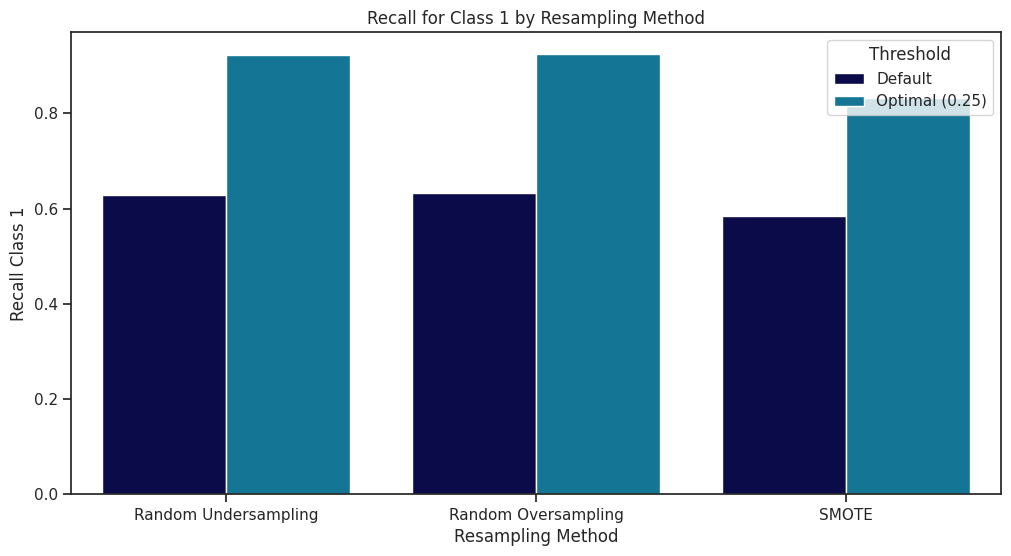

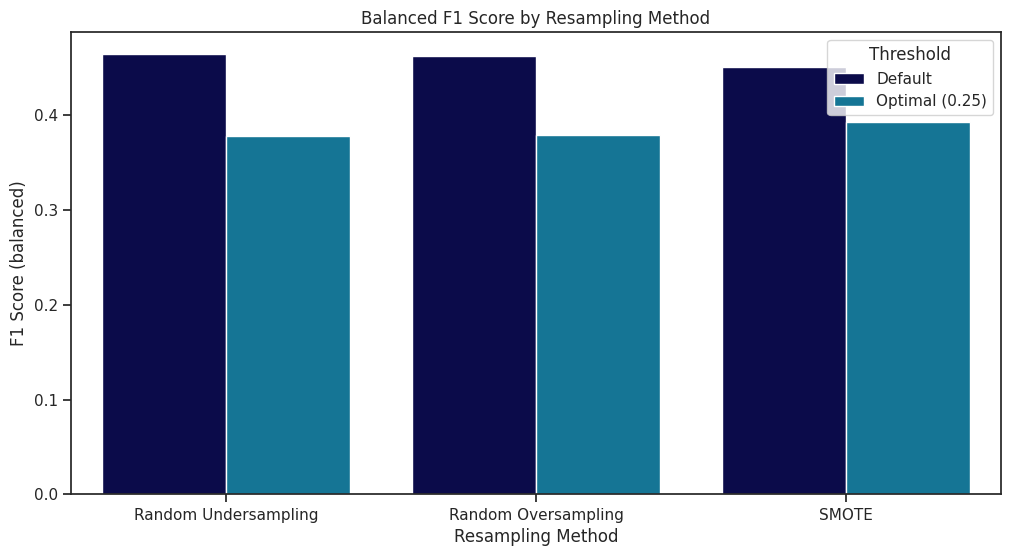

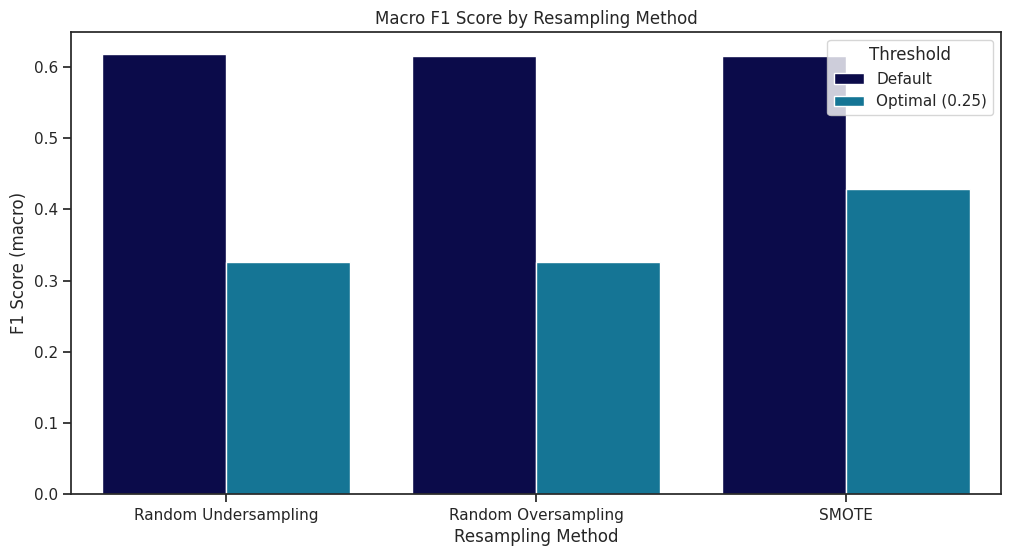

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot the performance metrics for combined results
def plot_combined_metrics(results_df, metric, title, ylabel):
    sns.set_context('notebook')
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.barplot(x='Method', y=metric, hue='Threshold', data=results_df, palette='ocean', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Resampling Method')
    ax.set_ylabel(ylabel)

    plt.show()

# Metrics to plot
metrics = [
    ('Recall Class 1', 'Recall for Class 1 by Resampling Method', 'Recall Class 1'),
    ('F1 Score (balanced)', 'Balanced F1 Score by Resampling Method', 'F1 Score (balanced)'),
    ('F1 Score (macro)', 'Macro F1 Score by Resampling Method', 'F1 Score (macro)')
]

# Loop through the metrics and create plots
for metric, title, ylabel in metrics:
    plot_combined_metrics(final_results_df, metric, title, ylabel)


#### Interpretation of Final Results

#### Recall for Class 1 (Loan Defaults)
- **Default Threshold**:
  - **Random Undersampling**: 0.629
  - **Random Oversampling**: 0.632
  - **SMOTE**: 0.583

- **Optimal Threshold (0.25)**:
  - **Random Undersampling**: 0.923
  - **Random Oversampling**: 0.924
  - **SMOTE**: 0.833

**Analysis**:
- Using the optimal threshold of 0.25 significantly increased the recall for class 1 across all resampling methods.
- Both Random Undersampling and Random Oversampling achieved a recall of around 0.92 with the optimal threshold, showing a substantial improvement from the default threshold.
- SMOTE also showed a considerable increase in recall, from 0.583 to 0.833.

#### Balanced F1 Score
- **Default Threshold**:
  - **Random Undersampling**: 0.465
  - **Random Oversampling**: 0.463
  - **SMOTE**: 0.451

- **Optimal Threshold (0.25)**:
  - **Random Undersampling**: 0.379
  - **Random Oversampling**: 0.379
  - **SMOTE**: 0.393

**Analysis**:
- The balanced F1 score decreased for all resampling methods when using the optimal threshold.
- While recall improved significantly, the decrease in the balanced F1 score indicates a trade-off with precision, leading to a lower F1 score.

#### Macro F1 Score
- **Default Threshold**:
  - **Random Undersampling**: 0.618
  - **Random Oversampling**: 0.615
  - **SMOTE**: 0.615

- **Optimal Threshold (0.25)**:
  - **Random Undersampling**: 0.325
  - **Random Oversampling**: 0.326
  - **SMOTE**: 0.428

**Analysis**:
- The macro F1 score also decreased for Random Undersampling and Random Oversampling with the optimal threshold, similar to the balanced F1 score.
- SMOTE showed a smaller decrease in macro F1 score compared to the other methods, indicating a better balance between precision and recall across classes when using the optimal threshold.

### Conclusion
1. **Recall Improvement**:
   - Using the optimal threshold of 0.25 significantly improved recall for class 1 across all resampling methods, with Random Undersampling and Random Oversampling achieving recall values above 0.92.

2. **F1 Score Trade-offs**:
   - The increase in recall came at the cost of precision, leading to lower balanced F1 scores and macro F1 scores for Random Undersampling and Random Oversampling.
   - SMOTE managed to maintain a relatively better balance, showing a smaller decrease in F1 scores compared to the other methods.

3. **Recommendation**:
   - If the primary goal is to maximize recall for loan defaults (class 1), using the optimal threshold of 0.25 with Random Undersampling or Random Oversampling is effective.
   - However, if a better balance between precision and recall is desired, SMOTE with the optimal threshold might be a better choice, given its relatively higher F1 scores.

### Write Loan Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None



'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py
